<a href="https://colab.research.google.com/github/soomin9106/Deep-Learning/blob/main/Anomaly_Detection_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Anomaly Detection using AutoEncoder

using MNIST fashion dataset as normal data

In [ ]:
#module import 

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
#module import for CNN
from tensorflow.keras.layers import Layer, Input, Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization, LeakyReLU, Conv2DTranspose
from tensorflow.keras.models import Model

In [ ]:
#data import(MNIST-fashion dataset)

from tensorflow.keras.datasets import fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [ ]:
#image shape : (data count, 28,28,1) (channel last)
train_images = np.reshape(train_images, (train_images.shape[0],28,28,1))
test_images = np.reshape(test_images, (test_images.shape[0],28,28,1))
print("train dataset shape:", train_images.shape, train_labels.shape)
print("test dataset shape:", test_images.shape, test_labels.shape)

train dataset shape: (60000, 28, 28, 1) (60000,)
test dataset shape: (10000, 28, 28, 1) (10000,)


In [ ]:
# 데이터 전처리
def get_preprocessed_data(images):
    
    # 학습과 테스트 이미지 array를 0~1 사이값으로 scale 및 float32 형 변형. 
    images = np.array(images/255.0, dtype=np.float32)
    return images

In [ ]:
train_images = get_preprocessed_data(train_images)
test_images = get_preprocessed_data(test_images)

AutoEncoder Architecture

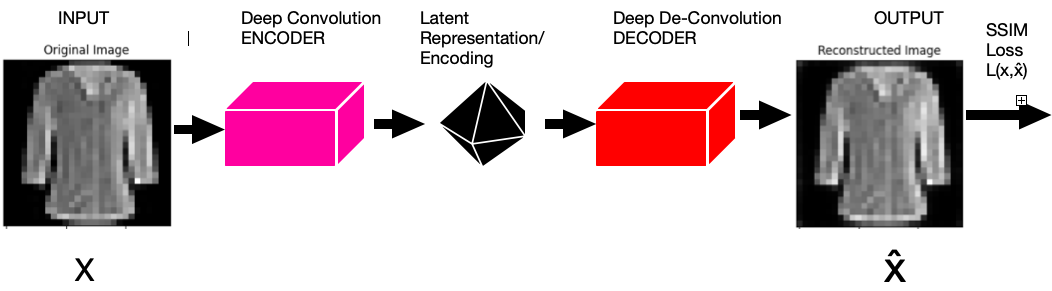

In [ ]:
#model function

IMAGE_SIZE = 28
BATCH_SIZE = 64


def autoencoder_model(verbose = False):
  input_tensor = Input(shape = (IMAGE_SIZE, IMAGE_SIZE,1)) #인풋 사이즈 지정

  #encoding part
  #인코딩 : 컨볼루션 => 배치 정규화 => ReLU Activation 적용
  x = Conv2D(32 , kernel_size = (3,3), strides = 1, padding = 'same', name = 'conv_1')(input_tensor)
  x = BatchNormalization(name = 'batchnorm_1')(x)
  x = LeakyReLU(name = 'leaky_relu_1')(x)

  x = Conv2D(64 , kernel_size = (3,3), strides = 2, padding = 'same', name = 'conv_2')(x)
  x = BatchNormalization(name = 'batchnorm_2')(x)
  x = LeakyReLU(name = 'leaky_relu_2')(x)

  x = Conv2D(64 , kernel_size = (3,3), strides = 2, padding = 'same', name = 'conv_3')(x)
  x = BatchNormalization(name = 'batchnorm_3')(x)
  x = LeakyReLU(name = 'leaky_relu_3')(x)

  #decoding part
  #디코딩 : transpose convolution => 배치 정규화 => 활성화 함수 적용
  x = Conv2DTranspose(64, kernel_size = (3,3), strides = 1, padding = 'same', name = 'conv_transpose_1')(x)
  x = BatchNormalization(name = 'batchnorm_4')(x)
  x = LeakyReLU(name = 'leaky_relu_4')(x)

  x = Conv2DTranspose(64, kernel_size = (3,3), strides = 2, padding = 'same', name = 'conv_transpose_2')(x)
  x = BatchNormalization(name = 'batchnorm_5')(x)
  x = LeakyReLU(name = 'leaky_relu_5')(x)

  x = Conv2DTranspose(32, kernel_size = (3,3), strides = 2, padding = 'same', name = 'conv_transpose_3')(x)
  x = BatchNormalization(name = 'batchnorm_6')(x)
  x = LeakyReLU(name = 'leaky_relu_6')(x)

  output = Conv2DTranspose(1, kernel_size = (3,3), strides = 1, padding = 'same', activation = 'sigmoid', name = 'output_layer')(x) #시그모이드 적용, Anomaly or not 의 결과를 return

  model = Model(inputs =input_tensor, outputs = output)

  if verbose:
    model.summary()
  
  return model

In [ ]:
# defining SSIM(Structural Similarity Index)

def SSIMLoss(y_true, y_pred):
  return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred,1.0))

In [ ]:
model = autoencoder_model()

from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(0.001), loss=SSIMLoss)

In [ ]:
history = model.fit(train_images,train_images, batch_size=BATCH_SIZE, epochs=30, shuffle = True,
                    validation_data = (test_images, test_images))

Epoch 1/30
938/938 [==============================] - 33s 32ms/step - loss: 0.0475 - val_loss: 0.0190
Epoch 2/30
938/938 [==============================] - 22s 23ms/step - loss: 0.0150 - val_loss: 0.0129
Epoch 3/30
938/938 [==============================] - 21s 23ms/step - loss: 0.0108 - val_loss: 0.0105
Epoch 4/30
938/938 [==============================] - 21s 23ms/step - loss: 0.0091 - val_loss: 0.0097
Epoch 5/30
938/938 [==============================] - 21s 22ms/step - loss: 0.0077 - val_loss: 0.0105
Epoch 6/30
938/938 [==============================] - 22s 23ms/step - loss: 0.0068 - val_loss: 0.0077
Epoch 7/30
938/938 [==============================] - 21s 23ms/step - loss: 0.0061 - val_loss: 0.0074
Epoch 8/30
938/938 [==============================] - 21s 22ms/step - loss: 0.0056 - val_loss: 0.0042
Epoch 9/30
938/938 [==============================] - 21s 22ms/step - loss: 0.0053 - val_loss: 0.0062
Epoch 10/30
938/938 [==============================] - 21s 22ms/step - loss: 0.004

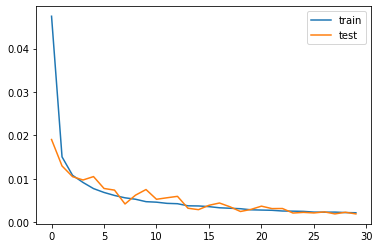

In [ ]:
#학습 데이터 loss 와 validation loss 확인
def show_history(history):
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    
show_history(history)

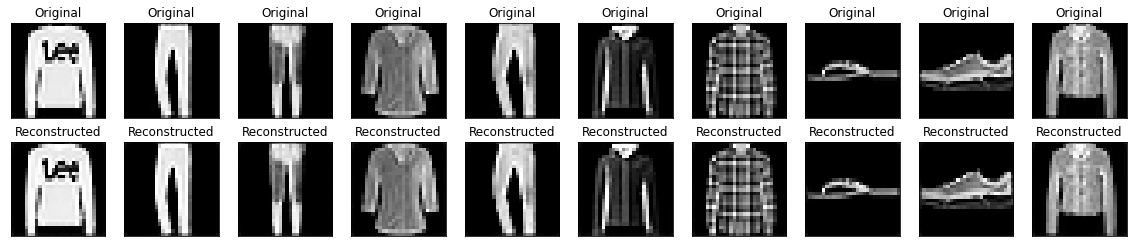

In [ ]:
#visualization reconstructed images
# autoencoder 로 만들어지는 이미지 시각화 하는 로직
decoded_imgs = model.predict(test_images)
n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(test_images[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    plt.title("Original")
    ax.get_yaxis().set_visible(False)
    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.title("Reconstructed")
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

#예제 모델로 이미지를 잘 만들어내는 것을 확인 할 수 있음

In [ ]:
#comparing loss of normal images and anomaly images
# bring data from mnist (including data which are not fashion)

# 패션 데이터가 아닌 데이터셋을 이상치 데이터로 하기 위해 다른 데이터 import

mnist = tf.keras.datasets.mnist
(x_mnisttrain, _), (x_mnisttest, _) = mnist.load_data()
x_mnisttrain = x_mnisttrain.astype('float32') / 255.
x_mnisttest = x_mnisttest.astype('float32') / 255.
x_mnisttrain = np.reshape(x_mnisttrain, (len(x_mnisttrain), 28, 28, 1))
x_mnisttest = np.reshape(x_mnisttest, (len(x_mnisttest), 28, 28, 1))

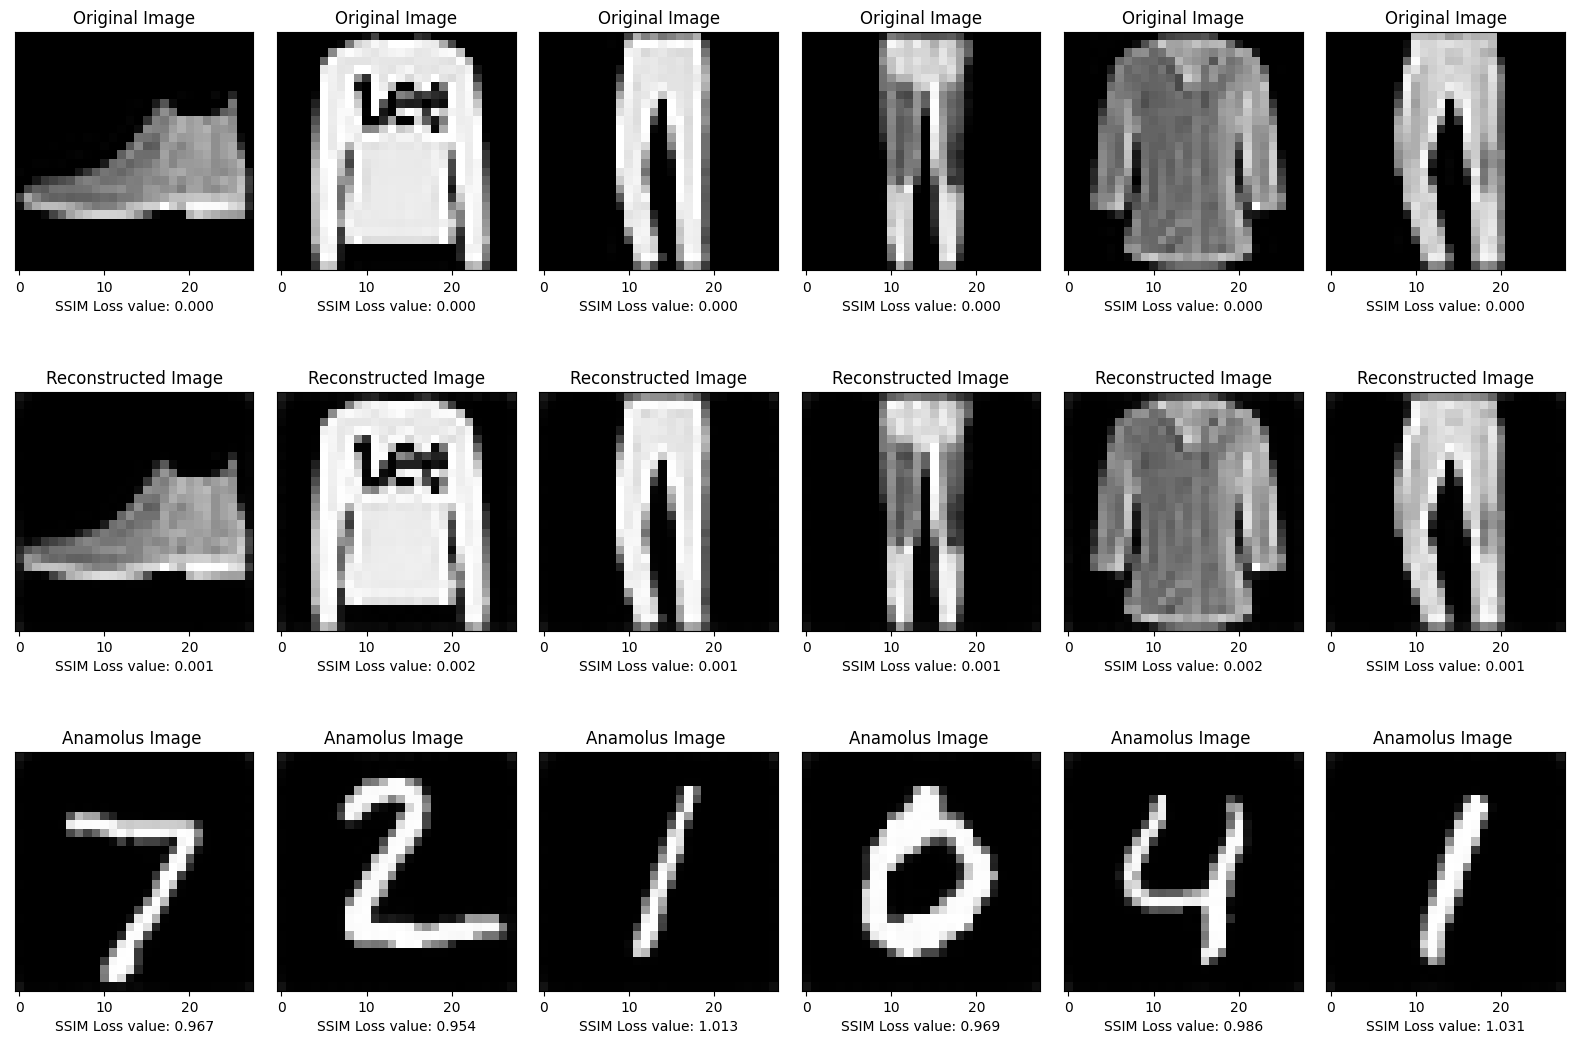

In [ ]:
# 정상 데이터(패션 데이터)와 이상 데이터의 loss 값을 비교

%matplotlib inline
n = 6  # how many encoded and decoded images we will display
decoded_imgs= model.predict(test_images)
decoded_mnistimgs= model.predict(x_mnisttest)
plt.figure(figsize=(20, 14), dpi=100)
plt.subplots_adjust( wspace=0.1, hspace=0.07)
plt_a=1
for i in range(n):
    # Original training dataset vs Original training
    ax = plt.subplot(3, n, plt_a   )
    plt.imshow(test_images[i].reshape(28,28))
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(False)
    value_a = SSIMLoss(test_images[i], test_images[i])
    ax.set_title("Original Image")
    label = 'SSIM Loss value: {:.3f}'
    ax.set_xlabel(label.format(value_a) )
    
    # Reconstructed good data  vs Original training data
    ax = plt.subplot(3, n, plt_a + n )
    plt.imshow(decoded_imgs[i].reshape(28,28))
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(False)    
    value_a = SSIMLoss(decoded_imgs[i], test_images[i])
    ax.set_title("Reconstructed Image")
    label = 'SSIM Loss value: {:.3f}'
    ax.set_xlabel(label.format(value_a) )
    
    # Reconstructed anomalous data  vs Original training data
    ax = plt.subplot(3, n, plt_a + 2*n)
    plt.imshow(decoded_mnistimgs[i].reshape(28,28))
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(False)
    value = SSIMLoss(decoded_mnistimgs[i], decoded_imgs[i])
    label = 'SSIM Loss value: {:.3f}'
    ax.set_title("Anamolus Image " )
    ax.set_xlabel(label.format(value) )
    plt_a+=1
plt.show()

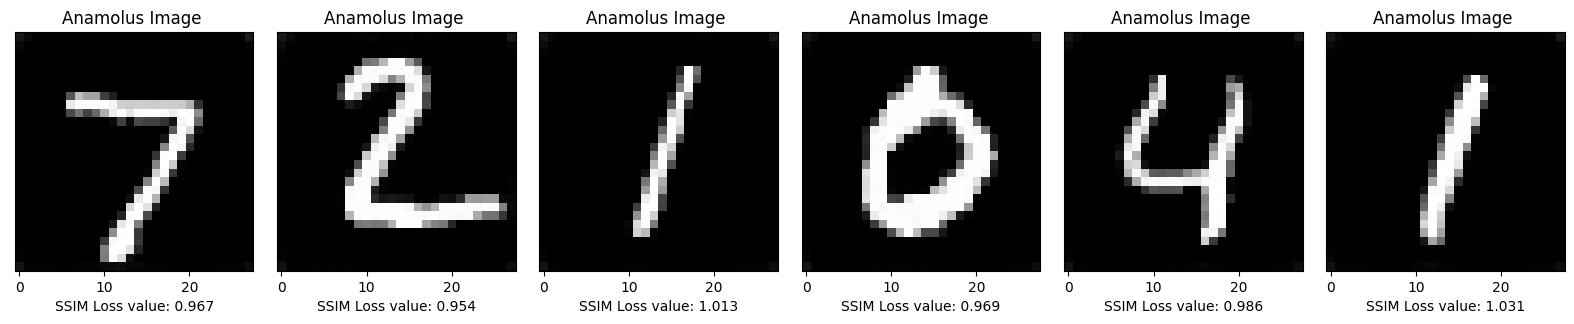

In [ ]:
plt.figure(figsize=(20, 14), dpi=100)
plt.subplots_adjust( wspace=0.1, hspace=0.07)
plt_a=1
for i in range(n):
    # Reconstructed anomalous data  vs Original training data
    ax = plt.subplot(3, n, plt_a + 2*n)
    plt.imshow(decoded_mnistimgs[i].reshape(28,28))
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(False)
    value = SSIMLoss(decoded_mnistimgs[i], decoded_imgs[i])
    label = 'SSIM Loss value: {:.3f}'
    ax.set_title("Anamolus Image " )
    ax.set_xlabel(label.format(value) )
    plt_a+=1
plt.show()

In [ ]:
#학습된 모델에 이상치 데이터를 넣었을 때 SSIM Loss Value 값이 0.9 대로 올라감을 확인 할 수 있음. 

Text(0.5, 1.0, 'normal image that was not used in training')

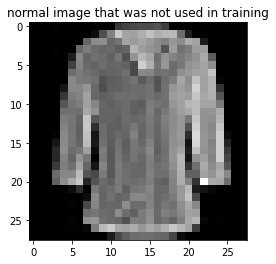

In [ ]:
# 정상 이미지 인풋 visualization
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(test_images[4].reshape(28,28),cmap='gray')
plt.title('normal image that was not used in training')

In [ ]:
# 해당 정상 이미지를 모델에 넣고 evaluate 를 진행 (with SSIM Loss value)
decoded_imgs= model.predict(test_images)

Text(0.5, 1.0, 'normal image decoded by model & SSIM Loss value : 0.002')

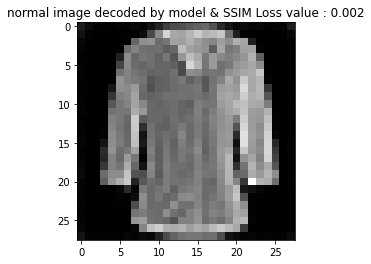

In [ ]:
loss_val = SSIMLoss(decoded_imgs[4], test_images[4])
plt.imshow(decoded_imgs[4].reshape(28,28),cmap='gray')
plt.title('normal image decoded by model & SSIM Loss value : {:.3f}'.format(loss_val))

Text(0.5, 1.0, 'abnormal image example')

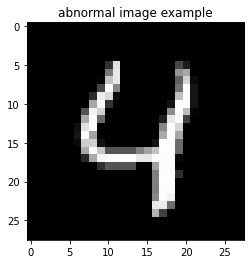

In [ ]:
# 비정상 이미지 visualization
plt.imshow(x_mnisttest[4].reshape(28,28),cmap='gray')
plt.title('abnormal image example')

In [ ]:
# 비정상 이미지를 모델에 넣고 evaluate 진행
decoded_mnistimgs= model.predict(x_mnisttest)

Text(0.5, 1.0, 'abnormal image decoded by model & SSIM Loss value : 0.985')

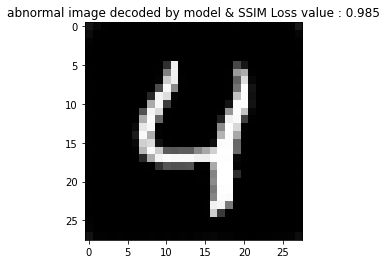

In [ ]:
loss_val = SSIMLoss(decoded_mnistimgs[4], test_images[4])
plt.imshow(decoded_mnistimgs[4].reshape(28,28),cmap='gray')
plt.title('abnormal image decoded by model & SSIM Loss value : {:.3f}'.format(loss_val))

In [ ]:
def detect_anomaly(decoded_img, test_image):
  isAnomaly = False
  plt.imshow(decoded_img.reshape(28,28),cmap='gray')
  plt.title('Is Anomaly Image?')
  loss_val = SSIMLoss(decoded_img, test_image)
  if(loss_val >= 0.1):
    isAnomaly = True
  if(isAnomaly):
    print('SSIM loss value is {:.3f}. So this is Anomaly'.format(loss_val))
  else:
    print('SSIM loss value is {:.3f}. So this is Normal'.format(loss_val))

SSIM loss value is 0.002. So this is Normal


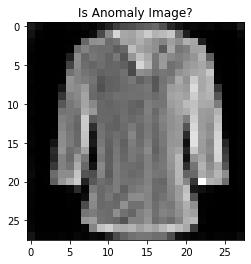

In [ ]:
detect_anomaly(decoded_imgs[4], test_images[4])

SSIM loss value is 0.985. So this is Anomaly


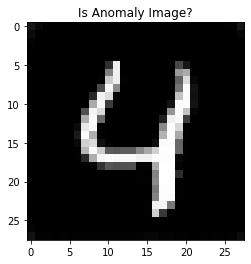

In [ ]:
detect_anomaly(decoded_mnistimgs[4], test_images[4])

SSIM loss value is 0.967. So this is Anomaly


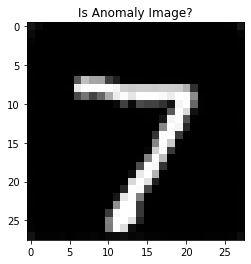

In [ ]:
detect_anomaly(decoded_mnistimgs[0], test_images[0])

SSIM loss value is 0.002. So this is Normal


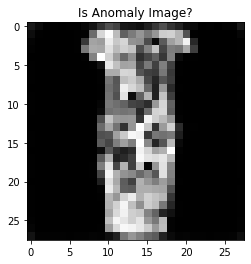

In [ ]:
detect_anomaly(decoded_imgs[100], test_images[100])

SSIM loss value is 0.002. So this is Normal


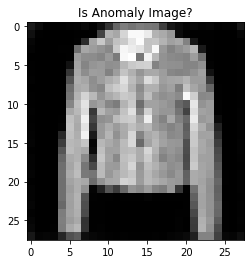

In [ ]:
detect_anomaly(decoded_imgs[10], test_images[10])

SSIM loss value is 1.004. So this is Anomaly


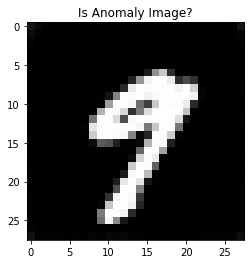

In [ ]:
detect_anomaly(decoded_mnistimgs[20], test_images[20])